In [ ]:
import re
import numpy as np
import pandas as pd
import torch
import tensorflow as tf
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from transformers import (
    BertTokenizer, BertModel, GPT2Tokenizer, GPT2Model, AutoModel, AutoTokenizer, AutoModelForMaskedLM,
    TFBertModel
)
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, SimpleRNN, Bidirectional, Dense, GRU, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import  f1_score, recall_score




# Data Loading and Cleaning

In [ ]:
# reading Data from file
from google.colab import drive
drive.mount('/content/drive/')
# reading Data from file
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Books_rating.csv')

# convert 'review/helpfulness' column to numeric and remove rows where the value is less than 0.5
# remain the helpful reviews
df[['numerator', 'denominator']] = df['review/helpfulness'].str.split('/', expand=True)
df['numerator'] = pd.to_numeric(df['numerator'], errors='coerce')
df['denominator'] = pd.to_numeric(df['denominator'], errors='coerce')
df['review/helpfulness'] = df['numerator'] / df['denominator']
df = df.drop(['numerator', 'denominator'], axis=1)
df = df[df['review/helpfulness'] >= 0.5]
# drop null values
df = df[['review/score','review/text']]
df.dropna(inplace = True)
# rename the column for better readability
df = df.rename(columns={'review/score': 'score', 'review/text': 'text'})

Mounted at /content/drive/


# Data Transformation


In [ ]:

# Set scores 1-2 as negative, 3 as neutral, and 4-5 as positive; then visualize the histogram of the data
# Define a function to map scores to sentiment labels
def map_score_to_sentiment(score):
    if score <= 2:
        return 'negative'
    elif score == 3:
        return 'neutral'
    else:
        return 'positive'

# Map sentiment labels
df['sentiment'] = df['score'].apply(map_score_to_sentiment)





In [ ]:
df.head(10)

,score,text,sentiment
0,4.0,This is only for Julie Strain fans. It's a col...,positive
1,5.0,I don't care much for Dr. Seuss but after read...,positive
2,5.0,"If people become the books they read and if ""t...",positive
3,4.0,"Theodore Seuss Geisel (1904-1991), aka &quot;D...",positive
4,4.0,Philip Nel - Dr. Seuss: American IconThis is b...,positive
5,4.0,"""Dr. Seuss: American Icon"" by Philip Nel is a ...",positive
6,5.0,Theodor Seuss Giesel was best known as 'Dr. Se...,positive
9,4.0,"As far as I am aware, this is the first book-l...",positive
10,5.0,"I just finished the book, &quot;Wonderful Wors...",positive
11,5.0,Many small churches feel like they can not hav...,positive


In [ ]:

# Define LabelEncoder
label_encoder = LabelEncoder()

# Encode sentiment labels as integers
df['label'] = label_encoder.fit_transform(df['sentiment'])

In [ ]:
df['label'] = pd.to_numeric(df['label'], downcast='integer')
samples_per_category = 1000
df = df.groupby('label').apply(lambda x: x.sample(n=samples_per_category, random_state=1)).reset_index(drop=True)
df = df.sample(frac=1, random_state=2).reset_index(drop=True)


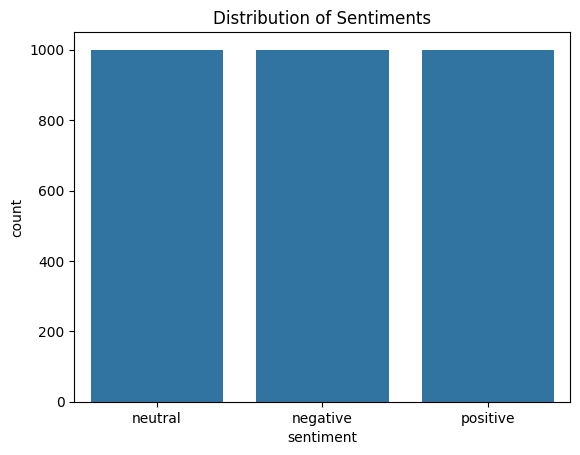

In [ ]:

# Visualize the distribution histogram of sentiment labels in the dataset
sns.countplot(x='sentiment', data=df)
plt.title('Distribution of Sentiments')
plt.show()



In [ ]:
df.shape

(3000, 4)

In [ ]:
df.head(10)

,score,text,sentiment,label
0,3.0,I very much looked forward to this book and re...,neutral,1
1,1.0,If this ghastly pastiche (or perhaps unintenti...,negative,0
2,1.0,"First off, let me say that I *like* sentimenta...",negative,0
3,5.0,"this book was great, but i never actually read...",positive,2
4,3.0,To bring Alexis de Tocqueville's concerns (esp...,neutral,1
5,3.0,This little book (almost 100 pages) was first ...,neutral,1
6,4.0,While everybody rates this book very highly (a...,positive,2
7,2.0,This is not a review of the content of the boo...,negative,0
8,1.0,I am extremely disappointed in the print quali...,negative,0
9,5.0,The words often found between the torn and tat...,positive,2


In [ ]:
# Assuming df is your DataFrame and 'score' is the column containing class labels
labels = LabelEncoder().fit(df['label']).transform(df['label'])
num_classes = 3

# Convert labels to one-hot encoding
labels = to_categorical(labels, num_classes=num_classes)


In [ ]:
# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased', trainable=True)
# Tokenize input text
encoded_data = tokenizer(list(df['text']), padding=True, truncation=True, return_tensors='tf')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
# Split the data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'], labels, test_size=0.2, random_state=42, stratify=labels
)
train_encoded_data = tokenizer(list(train_texts), padding=True, truncation=True, return_tensors='tf')
val_encoded_data = tokenizer(list(val_texts), padding=True, truncation=True, return_tensors='tf')

In [ ]:
train_encoded_data

{'input_ids': <tf.Tensor: shape=(2400, 512), dtype=int32, numpy=
array([[ 101, 1045, 4149, ...,    0,    0,    0],
       [ 101, 2025, 2069, ...,    0,    0,    0],
       [ 101, 1996, 2935, ...,    0,    0,    0],
       ...,
       [ 101, 1996, 3934, ...,    0,    0,    0],
       [ 101, 1045, 4149, ...,    0,    0,    0],
       [ 101, 1045, 2031, ...,    0,    0,    0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(2400, 512), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(2400, 512), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

In [ ]:
val_encoded_data

{'input_ids': <tf.Tensor: shape=(600, 512), dtype=int32, numpy=
array([[  101,  2023,  2338, ...,     0,     0,     0],
       [  101,  1045,  1005, ...,     0,     0,     0],
       [  101,  1996,  2338, ...,     0,     0,     0],
       ...,
       [  101,  1045,  2428, ...,     0,     0,     0],
       [  101,  8307,  5667, ...,     0,     0,     0],
       [  101, 20753,  1024, ...,     0,     0,     0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(600, 512), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(600, 512), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32

In [ ]:
train_labels

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.]], dtype=float32)

In [ ]:
val_labels

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.]], dtype=float32)

# Learning Model

In [ ]:
# Common Parameters
input_shape = (encoded_data['input_ids'].shape[1],)
num_classes = 3
bigru_units = 64
bilstm_units = 50
learning_rate = 1e-5
batch_size = 16
epochs = 10
validation_split = 0.2


In [ ]:
# 解决梯度问题！！好耶！
bert_model.trainable = True

In [ ]:
# Define input layer
input_layer = tf.keras.layers.Input(shape=input_shape, dtype=tf.int32, name="input_ids")

# Use BERT model
bert_output = bert_model(input_layer)['last_hidden_state']

# Bidirectional GRU layer with attention
bi_lstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(bigru_units, return_sequences=True))(bert_output)

# Bidirectional LSTM layer
bi_lstm2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(bilstm_units, return_sequences=True))(bi_lstm1)

# Global Max Pooling 1D layer
global_max_pooling = tf.keras.layers.GlobalMaxPooling1D()(bi_lstm2)

# Output layer
output_layer = tf.keras.layers.Dense(num_classes, activation='softmax')(global_max_pooling)

# Create the model
model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, 512)]             0         
                                                                 
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPo   109482240 
 )                           olingAndCrossAttentions             
                             (last_hidden_state=(Non             
                             e, 512, 768),                       
                              pooler_output=(None, 7             
                             68),                                
                              past_key_values=None,              
                             hidden_states=None, att             
                             entions=None, cross_att             
                             entions=None)                       
                                                             

# Model Training

In [ ]:
# Training the model
history = model.fit(train_encoded_data['input_ids'], train_labels, epochs=epochs, batch_size=batch_size, validation_split=validation_split)

Epoch 1/10


120/120 [==============================] - 4158s 34s/step - loss: 1.0394 - accuracy: 0.4516 - val_loss: 0.8903 - val_accuracy: 0.6000
Epoch 2/10
120/120 [==============================] - 4087s 34s/step - loss: 0.8177 - accuracy: 0.6401 - val_loss: 0.7688 - val_accuracy: 0.6542
Epoch 3/10
120/120 [==============================] - 4027s 33s/step - loss: 0.6406 - accuracy: 0.7484 - val_loss: 0.7298 - val_accuracy: 0.6750
Epoch 4/10
120/120 [==============================] - 4021s 34s/step - loss: 0.5040 - accuracy: 0.8036 - val_loss: 0.6625 - val_accuracy: 0.7229
Epoch 5/10
120/120 [==============================] - 3947s 33s/step - loss: 0.3736 - accuracy: 0.8708 - val_loss: 0.6654 - val_accuracy: 0.7146
Epoch 6/10
120/120 [==============================] - 4001s 33s/step - loss: 0.2777 - accuracy: 0.9172 - val_loss: 0.7616 - val_accuracy: 0.7063
Epoch 7/10
120/120 [==============================] - 3891s 32s/step - loss: 0.1973 - accuracy: 0.9438 - val_loss: 0.8053 - val_accuracy: 0.6

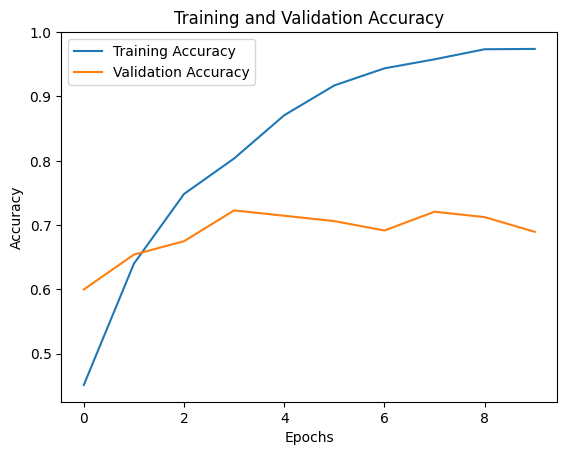

In [ ]:

# Plot learning curves
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


# Results

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix
import seaborn as sns
from sklearn.manifold import TSNE

# Prediction on the validation set
predictions = model.predict(val_encoded_data['input_ids'])

# Convert one-hot encoded predictions to class labels
predicted_labels = label_encoder.inverse_transform(predictions.argmax(axis=1))

# Convert one-hot encoded true labels to class labels
true_labels = label_encoder.inverse_transform(val_labels.argmax(axis=1))




19/19 [==============================] - 350s 18s/step


In [ ]:
# Evaluate accuracy, F1 score, and recall
accuracy = accuracy_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")


Accuracy: 0.7117
F1 Score: 0.7139
Recall: 0.7117


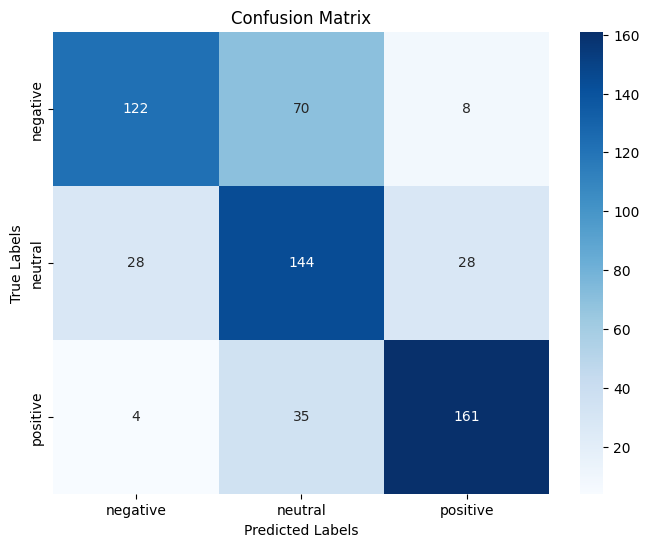

In [ ]:

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()